In [1]:
# import all libraries
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import minmax_scale
from scipy.sparse.linalg import svds
import json
from pandas import json_normalize
from datetime import datetime
pd.set_option('display.max_columns', 70)

In [3]:
# read all the csv files
reservations = pd.read_csv('./Downloads/datasets/reservations.csv')
res_cat = pd.read_csv('./Downloads/datasets/restaurant_category.csv')
res_cat_rel = pd.read_csv('./Downloads/datasets/res_cats_relationship.csv')

### Reservation data

In [4]:
reservations.head(10)

,rez_id,RestaurantUID,hashed_email,reservation_time,adults,children,client_type,booking_time,country_code
0,22LSM,13gastrowine1603gas,845609244659738b8e6344566d4110c1,1507289400,2,0,v3.3.3,1506930650,SG
1,22PC3,13gastrowine1603gas,122666f2210822f97e1754882caeb6f8,1507297500,3,0,v3.3.5,1506990529,SG
2,22RLN,13gastrowine1603gas,61ffd1c30c2d23acf9f28773a4ae6a46,1507293900,6,0,Mac OS X/Safari 602.1,1507011758,SG
3,22TUY,13gastrowine1603gas,20315e9c1bc332b95c4696e3c2b89299,1507204800,2,0,Mac OS X/Safari 603.2.5,1507027742,SG
4,22UN9,13gastrowine1603gas,02cb147aef506aae301e94e588187828,1507297500,2,0,Mac OS X/Safari 604.1,1507033231,SG
5,22WUD,13gastrowine1603gas,2d9e6ecf670d00aa7a036cf6ef4a1267,1507374000,4,0,3.3.5,1507087298,SG
6,22Z0F,13gastrowine1603gas,91065cb762843f7d19a158ebc55a0ca2,1507113900,5,0,Windows 7/Mozilla 5.0,1507102263,SG
7,232D5,13gastrowine1603gas,c41c91e77cd5492857ca8f49fa72aef4,1507378500,3,0,3.3.5,1507127970,SG
8,236KK,13gastrowine1603gas,4367a74143dd07a6ef017085a741f0a4,1507201200,4,0,Mac OS X/Safari 604.1,1507194426,SG
9,2.30E+03,13gastrowine1603gas,ab361af76c484f79fbce654889903383,1507285800,2,0,Mac OS X/Chrome 49.0.2623.112,1507279013,SG


In [5]:
reservations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517312 entries, 0 to 517311
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   rez_id            517312 non-null  object
 1   RestaurantUID     517312 non-null  object
 2   hashed_email      517312 non-null  object
 3   reservation_time  517312 non-null  int64 
 4   adults            517312 non-null  int64 
 5   children          517312 non-null  int64 
 6   client_type       471854 non-null  object
 7   booking_time      517312 non-null  int64 
 8   country_code      517312 non-null  object
dtypes: int64(4), object(5)
memory usage: 35.5+ MB


In [6]:
# convert reservations and booking time: from unix timestamp to pandas datetime
reservations['reservation_dt'] = pd.to_datetime(reservations['reservation_time'],unit='s')
reservations['booking_dt'] = pd.to_datetime(reservations['booking_time'],unit='s')

In [7]:
# Number of unique restaurants, users (hashed_email), client_type and country_code
print("unique restaurants count: ", reservations['RestaurantUID'].nunique())
print("unique users count: ", reservations['hashed_email'].nunique())
print("unique client_type count: ", reservations['client_type'].nunique())
print("unique country_code count: ", reservations['country_code'].nunique())

unique restaurants count:  2317
unique users count:  318372
unique client_type count:  990
unique country_code count:  11


In [8]:
# Country wise bookings distribution
reservations['country_code'].value_counts()

SG            397464
HK             48655
BANGKOK        23982
BALI           22097
JAKARTA        21390
PHUKET          2830
KHM              833
SOLO              34
MEDAN             22
KL                 3
LABUANBAJO         2
Name: country_code, dtype: int64

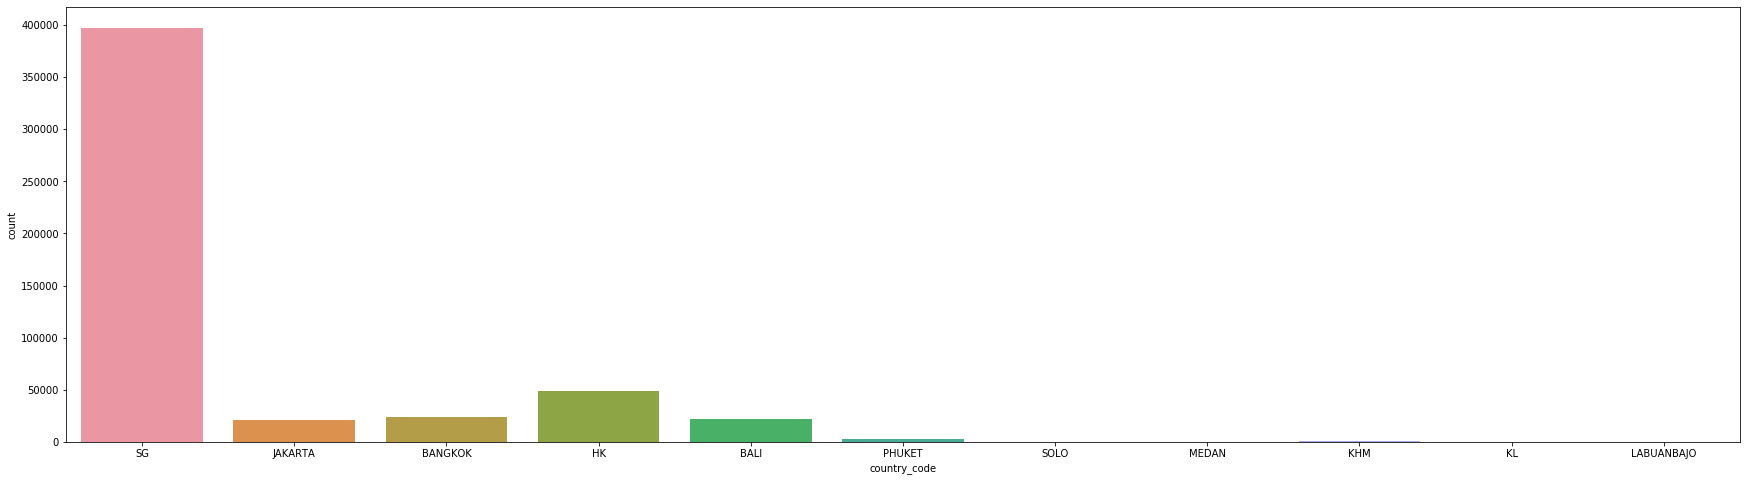

In [9]:
plt.subplots(figsize=(30, 8))
sns.countplot(data=reservations, x='country_code')

In [10]:
# check booking having adult count more than 100 and 500
print(len(reservations[reservations['adults']>100]))
print(len(reservations[reservations['adults']>500]))

59
1


### EDM interaction data

In [11]:
# read all the edm interaction json files 
edm_files_10 = './Downloads/datasets/test_edm_data/interactions_201710_test.txt'
edm_files_11 = './Downloads/datasets/test_edm_data/interactions_201711_test.txt'
edm_files_12 = './Downloads/datasets/test_edm_data/interactions_201712_test.txt'
f_10 = open(edm_files_10)
edm_contents_10 = f_10.readlines()
f_11 = open(edm_files_11)
edm_contents_11 = f_11.readlines()
f_12 = open(edm_files_12)
edm_contents_12 = f_12.readlines()
edm_contents = edm_contents_10 + edm_contents_11 + edm_contents_12
json_list = [json.loads(line) for line in edm_contents] # convert all the text to proper json structured data

In [12]:
print(len(edm_contents_10))
print(len(edm_contents_11))
print(len(edm_contents_12))
print(len(edm_contents))
print(len(json_list))
json_list[:10]

1845996
1682594
1767409
5295999
5295999


[{'campaign_id': '9c3c207eec',
  'email_hash': 'c0907d3d844ae6df9256923bcf9d6cad',
  'action': 'open',
  'timestamp': '2017-10-02 09:48:09',
  'url': None,
  'ip': '118.200.34.206'},
 {'campaign_id': '9c3c207eec',
  'email_hash': '43a73bdca2b2278b8e7b154d28cf5da1',
  'action': 'open',
  'timestamp': '2017-10-02 09:53:51',
  'url': None,
  'ip': '54.152.155.163'},
 {'campaign_id': '9c3c207eec',
  'email_hash': '667004054a2cb71655d3101bfdbe8783',
  'action': 'open',
  'timestamp': '2017-10-02 09:55:19',
  'url': None,
  'ip': '111.65.44.84'},
 {'campaign_id': '9c3c207eec',
  'email_hash': '627f3c8aef8e3307aa2d86d0371339b1',
  'action': 'open',
  'timestamp': '2017-10-02 09:53:07',
  'url': None,
  'ip': '111.65.45.45'},
 {'campaign_id': '9c3c207eec',
  'email_hash': 'c21664ad17a905eaa4fcce93861afe50',
  'action': 'open',
  'timestamp': '2017-10-02 09:44:32',
  'url': None,
  'ip': '64.233.173.59'},
 {'campaign_id': '9c3c207eec',
  'email_hash': 'f55cd3dfcfb0dc447dc69000e29e4aef',
  'acti

In [13]:
# convert jsons to pandas dataframe
edm_df = json_normalize(json_list)
edm_df

,campaign_id,email_hash,action,timestamp,url,ip
0,9c3c207eec,c0907d3d844ae6df9256923bcf9d6cad,open,2017-10-02 09:48:09,None,118.200.34.206
1,9c3c207eec,43a73bdca2b2278b8e7b154d28cf5da1,open,2017-10-02 09:53:51,None,54.152.155.163
2,9c3c207eec,667004054a2cb71655d3101bfdbe8783,open,2017-10-02 09:55:19,None,111.65.44.84
3,9c3c207eec,627f3c8aef8e3307aa2d86d0371339b1,open,2017-10-02 09:53:07,None,111.65.45.45
4,9c3c207eec,c21664ad17a905eaa4fcce93861afe50,open,2017-10-02 09:44:32,None,64.233.173.59
...,...,...,...,...,...,...
5295994,3705506a3d,baccc725094f5def3cc52993e9e69a67,click,2017-12-31 15:21:42,https://www.chope.co/hong-kong-restaurants/lis...,124.217.188.158
5295995,3705506a3d,baccc725094f5def3cc52993e9e69a67,open,2018-01-02 06:33:25,None,218.102.34.81
5295996,3705506a3d,baccc725094f5def3cc52993e9e69a67,open,2018-01-05 11:25:20,None,203.145.94.8
5295997,3705506a3d,e3d145ddd585831d67504c54f491fd49,open,2017-12-31 23:49:05,None,45.64.242.29


In [14]:
# check open vs clicked EDMs
edm_df['action'].value_counts()

open     5060153
click     235846
Name: action, dtype: int64

Based on above, click ratio is just 4.4%

In [15]:
print("Unique campaign count: ",edm_df['campaign_id'].nunique())
print("Records count having non-null URL: ",len(edm_df[pd.notna(edm_df['url'])]))

Unique campaign count:  521
Records count having non-null URL:  235846


In [16]:
edm_df[pd.notna(edm_df['url'])]['url'][16]

'https://book.chope.co/booking?rid=botanicoatthegarage68zcv45r5&sub_source=edm_promo_SG_chopeexclusives_02102017&source=chope&utm_source=Chope&utm_campaign=9c3c207eec-20171002+SG+Chope+Exclusives+Wildseed+Schmear&utm_medium=email&utm_term=0_ebc1ab0d07-9c3c207eec-[LIST_EMAIL_ID]&goal=0_ebc1ab0d07-9c3c207eec-[LIST_EMAIL_ID]&mc_cid=9c3c207eec&mc_eid=[UNIQID]'

In [17]:
edm_df[pd.notna(edm_df['url'])]['url'][36]

'https://d2jzxcrnybzkkt.cloudfront.net/uploads/2017/10/Chope_Exclusives_Menu_bn2_png_1506925980.png?utm_source=Chope&utm_campaign=9c3c207eec-20171002+SG+Chope+Exclusives+Wildseed+Schmear&utm_medium=email&utm_term=0_ebc1ab0d07-9c3c207eec-[LIST_EMAIL_ID]&goal=0_ebc1ab0d07-9c3c207eec-[LIST_EMAIL_ID]&mc_cid=9c3c207eec&mc_eid=[UNIQID]'

URL structure seems to be inconsistent and extracting restaurants Id would be difficult

### Restaurant_category data

In [18]:
print(res_cat.shape)
res_cat.head(10)

(631, 4)


,id,parent_id,name,country_code
0,1,0,CUISINE,SG
1,2,0,LOCATION,SG
2,6,1,American,SG
3,8,1,Bar,SG
4,11,2,Dempsey,SG
5,13,1,Buffet,SG
6,14,1,Modern European,SG
7,15,1,Chinese,SG
8,16,1,Japanese,SG
9,17,1,Korean,SG


In [19]:
# check count of unique category names, ids, parent_ids and parent category
print("unique categories name count:",res_cat['name'].nunique())
print("unique categories id count:",res_cat['id'].nunique())
print("unique parent_id count:",res_cat['parent_id'].nunique())
parent_ids = res_cat['parent_id'].unique()
res_cat[res_cat['id'].isin(parent_ids)]['name'].unique()

unique categories name count: 370
unique categories id count: 631
unique parent_id count: 21


array(['CUISINE', 'LOCATION', 'Location', 'Cuisine'], dtype=object)

### Res_cats_relationship

In [20]:
res_cat_rel.head(10)

,RestaurantUID,cat_id
0,1,1
1,1,2
2,1,35
3,1,36
4,1,37
5,1,54
6,1,60
7,1,77
8,1,79
9,1,80


In [21]:
print(res_cat_rel.shape)
# Check count of unique restaurants and cat_ids in res_cat_relationship data
print("count of unique restaurants: ", res_cat_rel['RestaurantUID'].nunique())
print("count of unique cat_ids: ", res_cat_rel['cat_id'].nunique())

(72920, 2)
count of unique restaurants:  3801
count of unique cat_ids:  941


In [22]:
# check missing cat ids that are not in restaurant_category data and also print those ids
print("count of missing cat ids:", len(set(res_cat_rel['cat_id']) - set(res_cat['id'])))
set(res_cat_rel['cat_id']) - set(res_cat['id'])

count of missing cat ids: 355


{0,
 35,
 36,
 37,
 41,
 43,
 45,
 47,
 49,
 53,
 54,
 55,
 56,
 58,
 60,
 64,
 67,
 68,
 75,
 76,
 77,
 78,
 79,
 80,
 86,
 87,
 144,
 176,
 178,
 214,
 215,
 216,
 217,
 218,
 219,
 255,
 256,
 257,
 258,
 259,
 266,
 268,
 270,
 271,
 272,
 288,
 290,
 295,
 319,
 320,
 325,
 326,
 327,
 329,
 332,
 333,
 335,
 337,
 359,
 360,
 361,
 363,
 364,
 365,
 366,
 367,
 368,
 369,
 370,
 371,
 372,
 373,
 374,
 375,
 410,
 412,
 414,
 420,
 421,
 424,
 426,
 427,
 428,
 429,
 431,
 439,
 440,
 442,
 444,
 446,
 448,
 452,
 489,
 495,
 512,
 522,
 523,
 524,
 526,
 527,
 528,
 530,
 531,
 533,
 536,
 537,
 538,
 539,
 540,
 541,
 542,
 543,
 544,
 547,
 549,
 618,
 620,
 632,
 638,
 639,
 640,
 641,
 664,
 682,
 692,
 703,
 705,
 706,
 776,
 777,
 778,
 779,
 780,
 781,
 782,
 783,
 784,
 785,
 786,
 787,
 788,
 789,
 790,
 840,
 841,
 842,
 843,
 844,
 845,
 846,
 847,
 848,
 849,
 850,
 851,
 876,
 881,
 882,
 883,
 884,
 885,
 886,
 887,
 888,
 889,
 890,
 891,
 919,
 920,
 921,
 922,
 

In [23]:
# Map cat ids to respective cat name and parent id by joining 2 tables res_cat_rel and res_cat
res_feat = pd.merge(res_cat_rel,res_cat,how='left',left_on='cat_id',right_on='id')
res_feat

,RestaurantUID,cat_id,id,parent_id,name,country_code
0,1,1,1.0,0.0,CUISINE,SG
1,1,2,2.0,0.0,LOCATION,SG
2,1,35,NaN,NaN,NaN,NaN
3,1,36,NaN,NaN,NaN,NaN
4,1,37,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
72915,zurriola91asd51a-4,270,NaN,NaN,NaN,NaN
72916,zurriola91asd51a-4,522,NaN,NaN,NaN,NaN
72917,zurriola91asd51a-4,526,NaN,NaN,NaN,NaN
72918,zurriola91asd51a-4,547,NaN,NaN,NaN,NaN


Most of the null values are because of missing cat ids in restaurant category table

In [24]:
# check records having non null cat ids and name
res_feat[pd.notna(res_feat['name'])]

,RestaurantUID,cat_id,id,parent_id,name,country_code
0,1,1,1.0,0.0,CUISINE,SG
1,1,2,2.0,0.0,LOCATION,SG
11,1,102,102.0,2.0,Holland Village,SG
12,1,103,103.0,2.0,Rochester,SG
13,111,1,1.0,0.0,CUISINE,SG
...,...,...,...,...,...,...
72905,zuma1503bkk,643,643.0,614.0,Ratchadamri,BANGKOK
72906,zurriola91asd51a-4,175,175.0,0.0,CUISINE,HK
72908,zurriola91asd51a-4,177,177.0,0.0,LOCATION,HK
72910,zurriola91asd51a-4,183,183.0,175.0,Modern European,HK


## Feature engineering

In [25]:
# get the total number of categories avaiable for each restaurant 
res_cat_count = res_cat_rel.groupby(['RestaurantUID'])['cat_id'].count().reset_index()
res_cat_count = res_cat_count.rename(columns={'cat_id':'cat_count'})
res_cat_count

,RestaurantUID,cat_count
0,1,13
1,111,16
2,112,15
3,1128bar1311bar,20
4,116,14
...,...,...
3796,zsgroupmoimoi1707mmn,18
3797,zsofitapasbar1501ztb,18
3798,zuccchero1704zce,15
3799,zuma1503bkk,5


In [26]:
res_cat_count['cat_count'].describe()

count    3801.000000
mean       19.184425
std         5.778675
min         1.000000
25%        16.000000
50%        19.000000
75%        22.000000
max       139.000000
Name: cat_count, dtype: float64

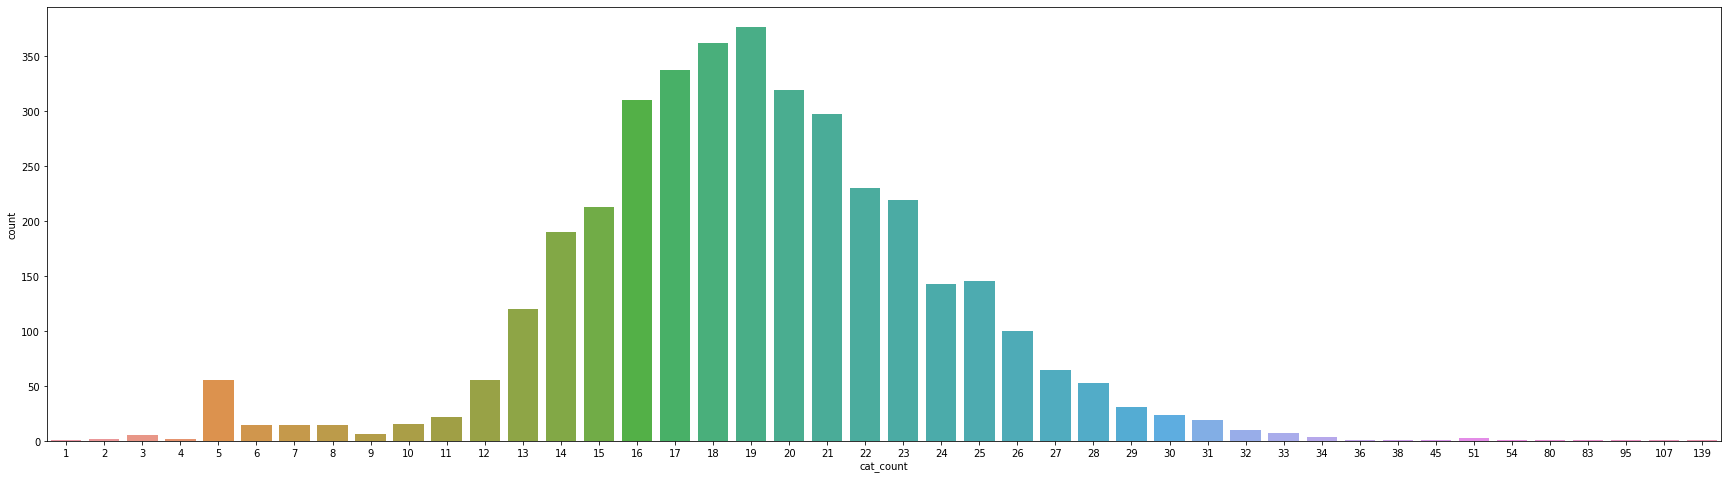

In [27]:
plt.subplots(figsize=(30, 8))
sns.countplot(data=res_cat_count, x='cat_count')

###### Insights: most of restaurants ( 25 to 75% percentile) offer 16 to 22 categories. Remaining restaurants in last quartile offers additional categories and those categories might not be avaiable across other restaurants. Hence, weightage for category count should be higher in recommendation model

In [28]:
# Get time gap between booking time and reservation time
reservations['time_gap_hr'] = (reservations['reservation_dt'] - reservations['booking_dt']).astype('timedelta64[h]')

# Get reservation hour
reservations['reservation_hr'] = reservations['reservation_dt'].dt.hour

# Check the distribution of all the bookings across different time hours to get peak hours
reservations['reservation_hr'].value_counts()

11    141535
10     94629
4      89667
12     69622
5      37107
13     19879
3      15700
9      11981
6      10780
7       8011
14      5257
2       4276
8       3634
1       2593
15      1516
0        486
16       353
23       129
21        60
22        51
17        35
18         7
19         4
Name: reservation_hr, dtype: int64

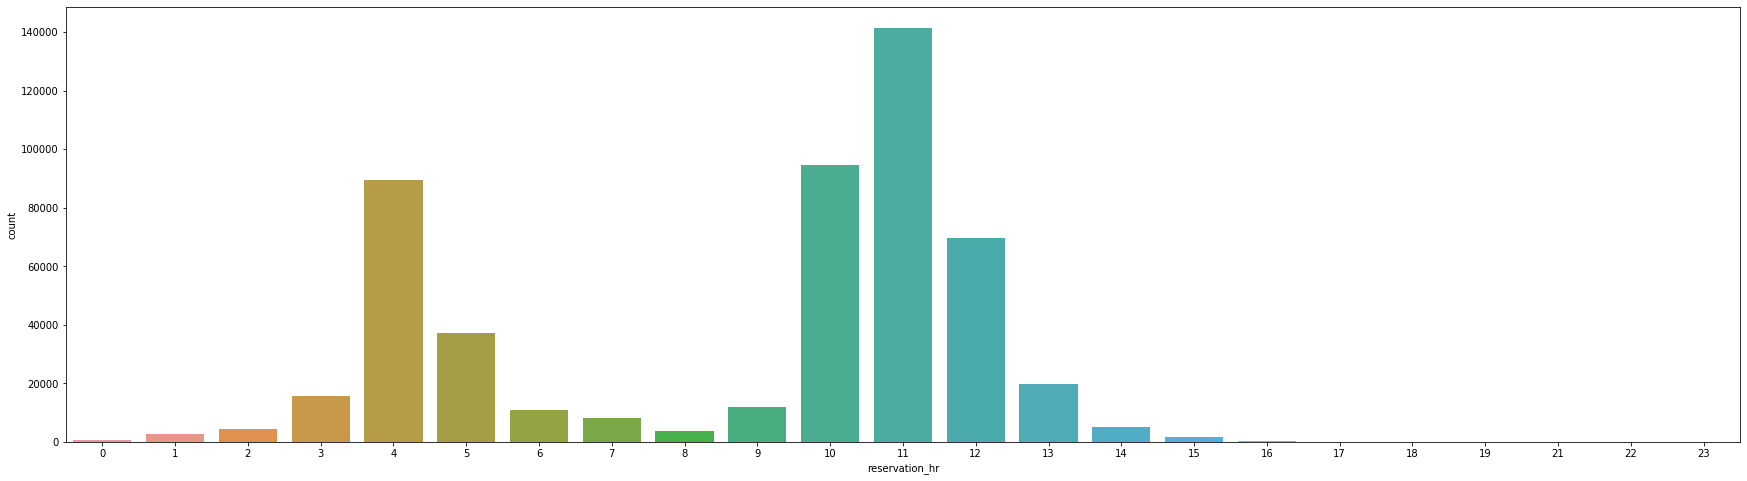

In [29]:
# plot the distribution of all the bookings across different time hours to get peak hours
plt.subplots(figsize=(30, 8))
sns.countplot(data=reservations, x='reservation_hr')

###### Insights: Based on above plot, peak hour for reservations are - 4 to 5 hr UTC and 10 to 12 hr UTC
For all the incoming bookings in peak hours, we should recommend more restaurants for each customer in case of un-availability

In [30]:
# add restaurant category count column in reservation tables
reservations_cat = pd.merge(reservations,res_cat_count,how='left',on='RestaurantUID')
reservations_cat.head(10)

,rez_id,RestaurantUID,hashed_email,reservation_time,adults,children,client_type,booking_time,country_code,reservation_dt,booking_dt,time_gap_hr,reservation_hr,cat_count
0,22LSM,13gastrowine1603gas,845609244659738b8e6344566d4110c1,1507289400,2,0,v3.3.3,1506930650,SG,2017-10-06 11:30:00,2017-10-02 07:50:50,99.0,11,16.0
1,22PC3,13gastrowine1603gas,122666f2210822f97e1754882caeb6f8,1507297500,3,0,v3.3.5,1506990529,SG,2017-10-06 13:45:00,2017-10-03 00:28:49,85.0,13,16.0
2,22RLN,13gastrowine1603gas,61ffd1c30c2d23acf9f28773a4ae6a46,1507293900,6,0,Mac OS X/Safari 602.1,1507011758,SG,2017-10-06 12:45:00,2017-10-03 06:22:38,78.0,12,16.0
3,22TUY,13gastrowine1603gas,20315e9c1bc332b95c4696e3c2b89299,1507204800,2,0,Mac OS X/Safari 603.2.5,1507027742,SG,2017-10-05 12:00:00,2017-10-03 10:49:02,49.0,12,16.0
4,22UN9,13gastrowine1603gas,02cb147aef506aae301e94e588187828,1507297500,2,0,Mac OS X/Safari 604.1,1507033231,SG,2017-10-06 13:45:00,2017-10-03 12:20:31,73.0,13,16.0
5,22WUD,13gastrowine1603gas,2d9e6ecf670d00aa7a036cf6ef4a1267,1507374000,4,0,3.3.5,1507087298,SG,2017-10-07 11:00:00,2017-10-04 03:21:38,79.0,11,16.0
6,22Z0F,13gastrowine1603gas,91065cb762843f7d19a158ebc55a0ca2,1507113900,5,0,Windows 7/Mozilla 5.0,1507102263,SG,2017-10-04 10:45:00,2017-10-04 07:31:03,3.0,10,16.0
7,232D5,13gastrowine1603gas,c41c91e77cd5492857ca8f49fa72aef4,1507378500,3,0,3.3.5,1507127970,SG,2017-10-07 12:15:00,2017-10-04 14:39:30,69.0,12,16.0
8,236KK,13gastrowine1603gas,4367a74143dd07a6ef017085a741f0a4,1507201200,4,0,Mac OS X/Safari 604.1,1507194426,SG,2017-10-05 11:00:00,2017-10-05 09:07:06,1.0,11,16.0
9,2.30E+03,13gastrowine1603gas,ab361af76c484f79fbce654889903383,1507285800,2,0,Mac OS X/Chrome 49.0.2623.112,1507279013,SG,2017-10-06 10:30:00,2017-10-06 08:36:53,1.0,10,16.0


In [31]:
# get the number of restaurants where category count is not available
reservations_cat[pd.isna(reservations_cat['cat_count'])]['RestaurantUID'].nunique()

60

In [32]:
## split the data into train-test here before doing any feature engineering based on all data to avoid any data leakage
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(reservations_cat, test_size=0.2, random_state=42)

In [33]:
train_df

,rez_id,RestaurantUID,hashed_email,reservation_time,adults,children,client_type,booking_time,country_code,reservation_dt,booking_dt,time_gap_hr,reservation_hr,cat_count
299476,258IE,nationalkitchenbyviolet1511nkv,e02b8072d028e5d20b3071502e594e4b,1508212800,3,0,3.3.5,1508154514,SG,2017-10-17 04:00:00,2017-10-16 11:48:34,16.0,4,18.0
486522,22PGN,vatosurbantacos1604vut,17c15a9c153d9875b5b37e1e4a0155ff,1507979700,6,0,3.3.4,1506993457,SG,2017-10-14 11:15:00,2017-10-03 01:17:37,273.0,11,24.0
447078,2GJ2J,tepbar1604bkk,c9d2c29bccc14c4b059394f49a4e5723,1513427400,2,0,Mac OS X/Safari 604.1,1513417296,BANGKOK,2017-12-16 12:30:00,2017-12-16 09:41:36,2.0,12,15.0
62827,27ORE,borngastarvista1512bnv,6ce6cc0e00c52df8ee5e92bb51afbd21,1509422400,6,0,Windows 7/Firefox 56.0,1509349009,SG,2017-10-31 04:00:00,2017-10-30 07:36:49,20.0,4,18.0
116763,22S15,diningworkshopdragonnoodlesacademy1611dna,8fbdb12ba388799a80282a5933133d64,1509789600,2,0,3.3.5,1507014887,HK,2017-11-04 10:00:00,2017-10-03 07:14:47,770.0,10,22.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259178,RG4SKG,level33872668a-4,1b148921c0d31d119eec465b3077bda8,1514347200,6,0,3.3.7,1512897636,SG,2017-12-27 04:00:00,2017-12-10 09:20:36,402.0,4,19.0
365838,R3VZNS,privechijmes32hsa77r14,5ade44f51ecf3a6530f19a4e0e73bb52,1514115000,2,0,Mac OS X/Safari 604.1,1514024785,SG,2017-12-24 11:30:00,2017-12-23 10:26:25,25.0,11,23.0
131932,22Y2G,fairmontprego1406pgo,4df175c482995b906c819a78ee34188d,1507370400,2,0,Linux/Chrome 61.0.3163.98,1507095407,SG,2017-10-07 10:00:00,2017-10-04 05:36:47,76.0,10,15.0
146867,RV3JFT,focrestaurant32hsa07a-4,c1251608825c27194dc4811cddbf1d49,1513916100,3,0,Mac OS X/Chrome 62.0.3202.94,1513818395,SG,2017-12-22 04:15:00,2017-12-21 01:06:35,27.0,4,22.0


In [34]:
# Calculate popularity score for each restaurant in each country based on total bookings in past 3 months
res_pop = train_df.groupby(['RestaurantUID','country_code'])['rez_id'].count().reset_index()
res_pop = res_pop.rename(columns={'rez_id':'popularity'})
res_pop

,RestaurantUID,country_code,popularity
0,13gastrowine1603gas,SG,95
1,13gastrowinekiliney1608gwk,SG,94
2,13gastrowinetelokayer1711wta,SG,23
3,1864bar1711bar,SG,7
4,1919waterboathouse1706wbh,SG,200
...,...,...,...
2303,zsgroupleelomei1707llm,HK,85
2304,zsgroupmexus1707mex,HK,60
2305,zsgroupmoimoi1707mmn,HK,28
2306,zsofitapasbar1501ztb,SG,17


We can also calculate restaurants popularity for each reservation hour if we have the reservation hour available for recommendations 

In [35]:
# Join train_df with res_pop to get the popularity column in train_df
train_df = pd.merge(train_df,res_pop,how='left',on=['RestaurantUID','country_code'])
train_df

,rez_id,RestaurantUID,hashed_email,reservation_time,adults,children,client_type,booking_time,country_code,reservation_dt,booking_dt,time_gap_hr,reservation_hr,cat_count,popularity
0,258IE,nationalkitchenbyviolet1511nkv,e02b8072d028e5d20b3071502e594e4b,1508212800,3,0,3.3.5,1508154514,SG,2017-10-17 04:00:00,2017-10-16 11:48:34,16.0,4,18.0,3503
1,22PGN,vatosurbantacos1604vut,17c15a9c153d9875b5b37e1e4a0155ff,1507979700,6,0,3.3.4,1506993457,SG,2017-10-14 11:15:00,2017-10-03 01:17:37,273.0,11,24.0,1147
2,2GJ2J,tepbar1604bkk,c9d2c29bccc14c4b059394f49a4e5723,1513427400,2,0,Mac OS X/Safari 604.1,1513417296,BANGKOK,2017-12-16 12:30:00,2017-12-16 09:41:36,2.0,12,15.0,77
3,27ORE,borngastarvista1512bnv,6ce6cc0e00c52df8ee5e92bb51afbd21,1509422400,6,0,Windows 7/Firefox 56.0,1509349009,SG,2017-10-31 04:00:00,2017-10-30 07:36:49,20.0,4,18.0,144
4,22S15,diningworkshopdragonnoodlesacademy1611dna,8fbdb12ba388799a80282a5933133d64,1509789600,2,0,3.3.5,1507014887,HK,2017-11-04 10:00:00,2017-10-03 07:14:47,770.0,10,22.0,446
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413844,RG4SKG,level33872668a-4,1b148921c0d31d119eec465b3077bda8,1514347200,6,0,3.3.7,1512897636,SG,2017-12-27 04:00:00,2017-12-10 09:20:36,402.0,4,19.0,3596
413845,R3VZNS,privechijmes32hsa77r14,5ade44f51ecf3a6530f19a4e0e73bb52,1514115000,2,0,Mac OS X/Safari 604.1,1514024785,SG,2017-12-24 11:30:00,2017-12-23 10:26:25,25.0,11,23.0,793
413846,22Y2G,fairmontprego1406pgo,4df175c482995b906c819a78ee34188d,1507370400,2,0,Linux/Chrome 61.0.3163.98,1507095407,SG,2017-10-07 10:00:00,2017-10-04 05:36:47,76.0,10,15.0,770
413847,RV3JFT,focrestaurant32hsa07a-4,c1251608825c27194dc4811cddbf1d49,1513916100,3,0,Mac OS X/Chrome 62.0.3202.94,1513818395,SG,2017-12-22 04:15:00,2017-12-21 01:06:35,27.0,4,22.0,2182


In [36]:
# Calculate customer’s frequency for each restaurant based on historical data
cust_res_freq = train_df[['rez_id','RestaurantUID','hashed_email']].drop_duplicates().groupby(['hashed_email','RestaurantUID'])['rez_id'].count().reset_index().sort_values('rez_id',ascending=False)
cust_res_freq = cust_res_freq.rename(columns={'rez_id':'cust_freq'})

In [37]:
print(len(cust_res_freq))
cust_res_freq

376107


,hashed_email,RestaurantUID,cust_freq
150546,666188c3e3e28ccdcc1e7f9ef5d6c674,jinjiteochewsteamboatjoochiat1506jjj,79
132172,5a157ab6e696aef3d116fea26edb12f5,jumboseafoodgallery35dfs43r6,73
326880,de5e3321d5519d4e7e0f05e7d1cedef5,jinjiteochewsteamboatjoochiat1506jjj,73
295373,c8ceac72b113529f84ad6d19156d4a62,corkscrewpi1703jkt,55
291362,c625da72fbbc9e72b10e6015a5c7bee8,hanarestaurant1503han,50
...,...,...,...
129879,5888623a6895ddf832e47f4c3bf6aabb,captainkprinsepstreet1704ckp,1
129878,588841e19d4d4526945c7adc15f2886b,jamiesitalian1502jmi,1
129877,588816a7549a145edec1e0aa6a0ed476,birdsofafeather1706bof,1
129876,5887f226869169fa072fc00ec1a8a623,cordismingcourt1603cmc,1


###### Since we don't have customer rating available for restaurants, we can consider this customer frequecy score similar to user ratings. 
###### Higher frequency means higher preferance and hence higher rating can be assumed. 
###### we can scale the customer frequency score between 1 to 5 to get an equivalent user rating

In [38]:
# Scale the customer frequency score between 1 to 5 to get an equivalent user rating
cust_res_freq['cust_freq_scaled'] = minmax_scale(cust_res_freq['cust_freq'],feature_range=(1, 5))
cust_res_freq

,hashed_email,RestaurantUID,cust_freq,cust_freq_scaled
150546,666188c3e3e28ccdcc1e7f9ef5d6c674,jinjiteochewsteamboatjoochiat1506jjj,79,5.000000
132172,5a157ab6e696aef3d116fea26edb12f5,jumboseafoodgallery35dfs43r6,73,4.692308
326880,de5e3321d5519d4e7e0f05e7d1cedef5,jinjiteochewsteamboatjoochiat1506jjj,73,4.692308
295373,c8ceac72b113529f84ad6d19156d4a62,corkscrewpi1703jkt,55,3.769231
291362,c625da72fbbc9e72b10e6015a5c7bee8,hanarestaurant1503han,50,3.512821
...,...,...,...,...
129879,5888623a6895ddf832e47f4c3bf6aabb,captainkprinsepstreet1704ckp,1,1.000000
129878,588841e19d4d4526945c7adc15f2886b,jamiesitalian1502jmi,1,1.000000
129877,588816a7549a145edec1e0aa6a0ed476,birdsofafeather1706bof,1,1.000000
129876,5887f226869169fa072fc00ec1a8a623,cordismingcourt1603cmc,1,1.000000


In [39]:
train_df = pd.merge(train_df,cust_res_freq,how='left',on=['hashed_email','RestaurantUID'])
train_df

,rez_id,RestaurantUID,hashed_email,reservation_time,adults,children,client_type,booking_time,country_code,reservation_dt,booking_dt,time_gap_hr,reservation_hr,cat_count,popularity,cust_freq,cust_freq_scaled
0,258IE,nationalkitchenbyviolet1511nkv,e02b8072d028e5d20b3071502e594e4b,1508212800,3,0,3.3.5,1508154514,SG,2017-10-17 04:00:00,2017-10-16 11:48:34,16.0,4,18.0,3503,1,1.000000
1,22PGN,vatosurbantacos1604vut,17c15a9c153d9875b5b37e1e4a0155ff,1507979700,6,0,3.3.4,1506993457,SG,2017-10-14 11:15:00,2017-10-03 01:17:37,273.0,11,24.0,1147,2,1.051282
2,2GJ2J,tepbar1604bkk,c9d2c29bccc14c4b059394f49a4e5723,1513427400,2,0,Mac OS X/Safari 604.1,1513417296,BANGKOK,2017-12-16 12:30:00,2017-12-16 09:41:36,2.0,12,15.0,77,1,1.000000
3,27ORE,borngastarvista1512bnv,6ce6cc0e00c52df8ee5e92bb51afbd21,1509422400,6,0,Windows 7/Firefox 56.0,1509349009,SG,2017-10-31 04:00:00,2017-10-30 07:36:49,20.0,4,18.0,144,1,1.000000
4,22S15,diningworkshopdragonnoodlesacademy1611dna,8fbdb12ba388799a80282a5933133d64,1509789600,2,0,3.3.5,1507014887,HK,2017-11-04 10:00:00,2017-10-03 07:14:47,770.0,10,22.0,446,2,1.051282
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413844,RG4SKG,level33872668a-4,1b148921c0d31d119eec465b3077bda8,1514347200,6,0,3.3.7,1512897636,SG,2017-12-27 04:00:00,2017-12-10 09:20:36,402.0,4,19.0,3596,1,1.000000
413845,R3VZNS,privechijmes32hsa77r14,5ade44f51ecf3a6530f19a4e0e73bb52,1514115000,2,0,Mac OS X/Safari 604.1,1514024785,SG,2017-12-24 11:30:00,2017-12-23 10:26:25,25.0,11,23.0,793,1,1.000000
413846,22Y2G,fairmontprego1406pgo,4df175c482995b906c819a78ee34188d,1507370400,2,0,Linux/Chrome 61.0.3163.98,1507095407,SG,2017-10-07 10:00:00,2017-10-04 05:36:47,76.0,10,15.0,770,2,1.051282
413847,RV3JFT,focrestaurant32hsa07a-4,c1251608825c27194dc4811cddbf1d49,1513916100,3,0,Mac OS X/Chrome 62.0.3202.94,1513818395,SG,2017-12-22 04:15:00,2017-12-21 01:06:35,27.0,4,22.0,2182,1,1.000000


In [40]:
# Transform the data into a pivot table
pivot_data = cust_res_freq.pivot(index = 'hashed_email', columns = 'RestaurantUID', values = 'cust_freq_scaled').fillna(0)
print(pivot_data.shape)
pivot_data.head()

(269722, 2302)


RestaurantUID,13gastrowine1603gas,13gastrowinekiliney1608gwk,13gastrowinetelokayer1711wta,1864bar1711bar,1919waterboathouse1706wbh,1953indonesien1610jkt,1tyrwhittbistrobar1508tbb,203seafoodwhitemeehoonfabulous1707mhf,22kitchen1503bkk,27bites1704bkk,28wilkieitalianrestaurantcaviarbar1702wik,4284,4285,4288,4347,4349,4350,4351,4352,4353,4412,4413,4616,4617,4618,4620,4633,4634,4635,4642,4750,4752,4753,4755,4922,...,yantrabyhemantoberoi1606yhb,yellowcabpizzaco1701ycb,yentakiniku1505yen,yeusaigoncafe1603jkt,yhingthaipalacerestaurant1608ypr,yonpachigyojo1612ypg,ytsb1503bkk,yuexinpot1710yxp,yuexuansf1710yxs,yumcha1512yca,yumchacentral1512ycact,yumchachinatown1409ycc,yummochow1706ymc,yuutarocentralembassy1512bkk,yuutarosukhumvit1511bkk,zaffronbananaleaf1705zbl,zaffronkitcheneastcoast1411zke,zaffronkitchenwestgate1504zwg,zenbuempo1703jkt,zenbugc1703jkt,zenbulivingw1703jkt,zenbupik1703jkt,zenbupuri1703jkt,zeneatphuket1711pkt,zestbarandterrace1511bkk,zetacafe1603bkk,zhjiangheen1612zjh,zibiru1605bal,zincgroupport1510zgport,zincgroupra1510zgra,zsgroupleelomei1707llm,zsgroupmexus1707mex,zsgroupmoimoi1707mmn,zsofitapasbar1501ztb,zuccchero1704zce
hashed_email,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
000016d31b46d5b64dec58ace9f0720d,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.051282,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.051282,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
000034f9763e2b654481b97d8752db51,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00005ad3e1efe6ca52efe1d67578048f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
000093aeb4c8baa4a506eccc36a2c343,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0000d6e86421d4156d76f14dfc569ac3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [41]:
cust_res_freq['hashed_email'].nunique()

269722

In this pivot table, 0 means, customers have not visited these restaurants at all, that means user rating is missing for these restaurant.
##### So we need to apply Singular Value Decomposition (SVD) and the components from SVD will be used to get the user ratings for all restaurants 



In [42]:
#SVD
U,s, VT = svds(pivot_data, k = 5)

#Construct diagonal array in SVD
sigma = np.diag(s)

#Applying SVD would output 3 parameters namely
print("U = ",U) #Orthogonal matrix
print('************************************************')
print("S = ",s) #Singular values
print('************************************************')
print("VT = ", VT) #Transpose of Orthogonal matrix


U =  [[ 1.01675741e-03 -1.38050550e-03  2.23414946e-03 -4.73642711e-04
  -2.36605336e-04]
 [ 2.02911308e-05 -4.23189686e-05  8.88137838e-05 -5.14333269e-05
  -3.81191028e-05]
 [-1.51417648e-03  1.10051839e-02  1.13018457e-02 -2.12220900e-03
  -6.63468308e-04]
 ...
 [ 2.71477461e-06 -9.37885736e-06  1.74042634e-05 -7.30690390e-06
  -9.02732672e-06]
 [ 2.54762356e-04 -1.40237945e-04  2.58913278e-04 -9.00004265e-05
  -3.33433396e-05]
 [ 1.32358225e-08  1.70378551e-09  2.03910738e-08 -4.72575141e-08
  -1.11489996e-08]]
************************************************
S =  [59.37903894 61.38462204 62.2109534  66.68084342 81.47872177]
************************************************
VT =  [[ 5.45554763e-04  1.45022538e-04  1.94553294e-04 ...  1.09182323e-05
   6.04777259e-05  2.02443261e-05]
 [-3.75469458e-04 -7.83990555e-04 -1.75962014e-04 ... -1.51254252e-05
  -5.10422058e-05 -1.42388505e-05]
 [ 8.72675561e-04  1.00534817e-03  3.18350157e-04 ...  4.59430320e-05
   8.63586932e-05  4.4736930

In [43]:
np.savetxt("./Desktop/Chope_group_assignment/Restaurant_Recommendation/data/svd_U.csv", U, delimiter=",")
np.savetxt("./Desktop/Chope_group_assignment/Restaurant_Recommendation/data/svd_sigma.csv", sigma, delimiter=",")
np.savetxt("./Desktop/Chope_group_assignment/Restaurant_Recommendation/data/svd_VT.csv", VT, delimiter=",")

In [44]:
# Get the predicted ratings for all the restaurants
all_predicted_ratings_df = np.dot(np.dot(U,sigma), VT)

#Predicted ratings
pred_data = pd.DataFrame(all_predicted_ratings_df, columns = pivot_data.columns)
pred_data.set_index(pivot_data.index,inplace = True)
pred_data.head()

RestaurantUID,13gastrowine1603gas,13gastrowinekiliney1608gwk,13gastrowinetelokayer1711wta,1864bar1711bar,1919waterboathouse1706wbh,1953indonesien1610jkt,1tyrwhittbistrobar1508tbb,203seafoodwhitemeehoonfabulous1707mhf,22kitchen1503bkk,27bites1704bkk,28wilkieitalianrestaurantcaviarbar1702wik,4284,4285,4288,4347,4349,4350,4351,4352,4353,4412,4413,4616,4617,4618,4620,4633,4634,4635,4642,4750,4752,4753,4755,4922,...,yantrabyhemantoberoi1606yhb,yellowcabpizzaco1701ycb,yentakiniku1505yen,yeusaigoncafe1603jkt,yhingthaipalacerestaurant1608ypr,yonpachigyojo1612ypg,ytsb1503bkk,yuexinpot1710yxp,yuexuansf1710yxs,yumcha1512yca,yumchacentral1512ycact,yumchachinatown1409ycc,yummochow1706ymc,yuutarocentralembassy1512bkk,yuutarosukhumvit1511bkk,zaffronbananaleaf1705zbl,zaffronkitcheneastcoast1411zke,zaffronkitchenwestgate1504zwg,zenbuempo1703jkt,zenbugc1703jkt,zenbulivingw1703jkt,zenbupik1703jkt,zenbupuri1703jkt,zeneatphuket1711pkt,zestbarandterrace1511bkk,zetacafe1603bkk,zhjiangheen1612zjh,zibiru1605bal,zincgroupport1510zgport,zincgroupra1510zgra,zsgroupleelomei1707llm,zsgroupmexus1707mex,zsgroupmoimoi1707mmn,zsofitapasbar1501ztb,zuccchero1704zce
hashed_email,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
000016d31b46d5b64dec58ace9f0720d,0.000191,0.000221,0.000073,0.000031,0.000420,1.047501e-07,0.000041,7.211764e-06,5.703439e-08,9.288561e-08,0.000324,0.000790,0.000562,0.000823,0.001436,0.000045,-4.325314e-19,8.207025e-06,1.814143e-05,1.970204e-06,0.000194,0.000400,0.001056,0.000441,0.000835,0.000160,0.000441,0.001673,5.273002e-07,1.401454e-05,0.000056,0.000072,2.319438e-05,0.000065,0.000441,...,0.000548,0.000085,0.000498,6.712849e-06,0.000357,0.000067,-5.527277e-19,8.521893e-07,1.035114e-08,0.000158,0.000286,0.000169,0.000179,2.926931e-06,6.650969e-10,0.000045,0.000580,0.000052,-5.528681e-20,4.662887e-19,1.346627e-19,-2.716306e-19,8.033058e-20,-5.787545e-19,-4.422692e-19,3.242253e-19,0.000047,0.000125,4.101445e-07,1.029418e-07,3.345354e-06,7.339588e-06,8.969044e-06,2.054205e-05,9.168014e-06
000034f9763e2b654481b97d8752db51,0.000007,0.000008,0.000003,0.000001,0.000017,3.963485e-09,0.000002,2.692408e-07,3.056273e-09,3.883070e-09,0.000012,0.000031,0.000022,0.000032,0.000055,0.000005,1.056821e-20,3.061058e-07,6.859187e-07,8.536639e-08,0.000007,0.000015,0.000041,0.000016,0.000032,0.000007,0.000024,0.000071,2.098734e-08,5.188019e-07,0.000006,0.000007,8.647678e-07,0.000002,0.000017,...,0.000021,0.000003,0.000019,2.448582e-07,0.000015,0.000003,2.100311e-20,3.249906e-08,5.711166e-10,0.000007,0.000013,0.000007,0.000006,3.883013e-07,2.804401e-11,0.000002,0.000023,0.000003,1.120183e-21,-2.407274e-21,-4.871182e-21,1.144688e-20,-1.812068e-21,2.666004e-20,2.125641e-20,-2.833443e-21,0.000002,0.000005,1.855549e-08,4.339149e-09,1.397448e-07,2.820219e-07,3.831997e-07,7.503610e-07,3.703395e-07
00005ad3e1efe6ca52efe1d67578048f,0.000330,0.000187,0.000097,0.000024,0.000569,2.680586e-07,0.000044,8.432376e-06,2.476253e-07,2.612478e-07,0.000458,0.001799,0.001794,0.001644,0.001572,0.000331,9.833849e-18,9.994539e-06,2.525087e-05,5.429151e-06,0.000154,0.000330,0.002054,0.000227,0.000968,0.000537,0.001150,0.004170,1.246989e-06,1.829773e-05,0.000373,0.000395,2.995752e-05,0.000034,0.001100,...,0.000388,0.000056,0.000292,6.233698e-06,0.000334,0.000298,1.383335e-17,1.383022e-06,1.436139e-07,0.000346,0.000428,0.000644,0.000065,-3.421139e-06,2.331562e-09,0.000020,0.001583,0.000042,1.183033e-18,-7.350011e-18,-3.573679e-18,7.814887e-18,-1.820179e-18,1.219867e-17,1.262757e-17,-5.556836e-18,0.000013,0.000309,8.828422e-07,2.118579e-07,5.738469e-06,7.269089e-06,2.375417e-05,2.310694e-05,2.218542e-05
000093aeb4c8baa4a506eccc36a2c343,0.000038,0.000044,0.000015,0.000006,0.000083,2.107166e-08,0.000008,1.431803e-06,1.128848e-08,1.870221e-08,0.000065,0.000158,0.000112,0.000165,0.000286,0.000009,-5.683142e-20,1.629137e-06,3.615997e-06,3.978191e-07,0.000039,0.000079,0.000211,0.000088,0.000165,0.000032,0.000087,0.000336,1.052288e-07,2.789949e-06,0.000011,0.000014,4.6179

In [45]:
# Get the average ratings for each restaurant based on average customers' frequency(visit) 
res_user_rating = cust_res_freq.groupby(['RestaurantUID'])['cust_freq'].mean().reset_index()
res_user_rating = res_user_rating.rename(columns={'cust_freq':'user_rating'})
res_user_rating

,RestaurantUID,user_rating
0,13gastrowine1603gas,1.043956
1,13gastrowinekiliney1608gwk,1.119048
2,13gastrowinetelokayer1711wta,1.045455
3,1864bar1711bar,1.000000
4,1919waterboathouse1706wbh,1.052632
...,...,...
2297,zsgroupleelomei1707llm,1.148649
2298,zsgroupmexus1707mex,1.176471
2299,zsgroupmoimoi1707mmn,1.000000
2300,zsofitapasbar1501ztb,1.000000


In [46]:
train_df = pd.merge(train_df,res_user_rating,how='left',on=['RestaurantUID'])
train_df

,rez_id,RestaurantUID,hashed_email,reservation_time,adults,children,client_type,booking_time,country_code,reservation_dt,booking_dt,time_gap_hr,reservation_hr,cat_count,popularity,cust_freq,cust_freq_scaled,user_rating
0,258IE,nationalkitchenbyviolet1511nkv,e02b8072d028e5d20b3071502e594e4b,1508212800,3,0,3.3.5,1508154514,SG,2017-10-17 04:00:00,2017-10-16 11:48:34,16.0,4,18.0,3503,1,1.000000,1.087888
1,22PGN,vatosurbantacos1604vut,17c15a9c153d9875b5b37e1e4a0155ff,1507979700,6,0,3.3.4,1506993457,SG,2017-10-14 11:15:00,2017-10-03 01:17:37,273.0,11,24.0,1147,2,1.051282,1.108213
2,2GJ2J,tepbar1604bkk,c9d2c29bccc14c4b059394f49a4e5723,1513427400,2,0,Mac OS X/Safari 604.1,1513417296,BANGKOK,2017-12-16 12:30:00,2017-12-16 09:41:36,2.0,12,15.0,77,1,1.000000,1.054795
3,27ORE,borngastarvista1512bnv,6ce6cc0e00c52df8ee5e92bb51afbd21,1509422400,6,0,Windows 7/Firefox 56.0,1509349009,SG,2017-10-31 04:00:00,2017-10-30 07:36:49,20.0,4,18.0,144,1,1.000000,1.043478
4,22S15,diningworkshopdragonnoodlesacademy1611dna,8fbdb12ba388799a80282a5933133d64,1509789600,2,0,3.3.5,1507014887,HK,2017-11-04 10:00:00,2017-10-03 07:14:47,770.0,10,22.0,446,2,1.051282,1.131980
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413844,RG4SKG,level33872668a-4,1b148921c0d31d119eec465b3077bda8,1514347200,6,0,3.3.7,1512897636,SG,2017-12-27 04:00:00,2017-12-10 09:20:36,402.0,4,19.0,3596,1,1.000000,1.105781
413845,R3VZNS,privechijmes32hsa77r14,5ade44f51ecf3a6530f19a4e0e73bb52,1514115000,2,0,Mac OS X/Safari 604.1,1514024785,SG,2017-12-24 11:30:00,2017-12-23 10:26:25,25.0,11,23.0,793,1,1.000000,1.064430
413846,22Y2G,fairmontprego1406pgo,4df175c482995b906c819a78ee34188d,1507370400,2,0,Linux/Chrome 61.0.3163.98,1507095407,SG,2017-10-07 10:00:00,2017-10-04 05:36:47,76.0,10,15.0,770,2,1.051282,1.154423
413847,RV3JFT,focrestaurant32hsa07a-4,c1251608825c27194dc4811cddbf1d49,1513916100,3,0,Mac OS X/Chrome 62.0.3202.94,1513818395,SG,2017-12-22 04:15:00,2017-12-21 01:06:35,27.0,4,22.0,2182,1,1.000000,1.134685


In [47]:
# Apply min-mix scaling on the required columns so that all the values will be in the same range
train_df['popularity_scaled'] = minmax_scale(train_df['popularity'])
train_df['cat_count_scaled'] = minmax_scale(train_df['cat_count'].fillna(0))
train_df['user_rating_scaled'] = minmax_scale(train_df['user_rating'])

In [48]:
# Pre-define the weightage for the ranking deciding factors based on hueristics 
# These weights can also be decided by running the A/B test experiment and 
# based on the experiment, we can get which factor should have higher weightage 
'''
Calculate the overall ratings for each restaurant based on user rating, categories offered and popularity
1. Assign the maximum weightage to user rating because restaurants having higher frequency of customers should be recommended more
2. Second highest weightage has been assigned to category count because only very few restaurants offer more than 30 categories and
some customers will have their preference to those categories and it won't be available at other restaurants 
3. Third deciding factor is restaurants' popularity in last 3 months
4. The weightage difference between cat_count and popularity should not be very high because 
if the difference between cat_count is not much and difference between popularity is high then
it should be adjusted and restaurant having higher popularity should be recommended 
'''

wt_user_rating = 0.45 
wt_cat_count = 0.30 
wt_popularity = 0.25 
train_df['res_overall_rating'] = (wt_user_rating * train_df['user_rating_scaled']) + (wt_cat_count * train_df['cat_count_scaled']) + (wt_popularity * train_df['popularity_scaled'])
train_df

,rez_id,RestaurantUID,hashed_email,reservation_time,adults,children,client_type,booking_time,country_code,reservation_dt,booking_dt,time_gap_hr,reservation_hr,cat_count,popularity,cust_freq,cust_freq_scaled,user_rating,popularity_scaled,cat_count_scaled,user_rating_scaled,res_overall_rating
0,258IE,nationalkitchenbyviolet1511nkv,e02b8072d028e5d20b3071502e594e4b,1508212800,3,0,3.3.5,1508154514,SG,2017-10-17 04:00:00,2017-10-16 11:48:34,16.0,4,18.0,3503,1,1.000000,1.087888,0.495473,0.129496,0.006761,0.165759
1,22PGN,vatosurbantacos1604vut,17c15a9c153d9875b5b37e1e4a0155ff,1507979700,6,0,3.3.4,1506993457,SG,2017-10-14 11:15:00,2017-10-03 01:17:37,273.0,11,24.0,1147,2,1.051282,1.108213,0.162139,0.172662,0.008324,0.096079
2,2GJ2J,tepbar1604bkk,c9d2c29bccc14c4b059394f49a4e5723,1513427400,2,0,Mac OS X/Safari 604.1,1513417296,BANGKOK,2017-12-16 12:30:00,2017-12-16 09:41:36,2.0,12,15.0,77,1,1.000000,1.054795,0.010753,0.107914,0.004215,0.036959
3,27ORE,borngastarvista1512bnv,6ce6cc0e00c52df8ee5e92bb51afbd21,1509422400,6,0,Windows 7/Firefox 56.0,1509349009,SG,2017-10-31 04:00:00,2017-10-30 07:36:49,20.0,4,18.0,144,1,1.000000,1.043478,0.020232,0.129496,0.003344,0.045412
4,22S15,diningworkshopdragonnoodlesacademy1611dna,8fbdb12ba388799a80282a5933133d64,1509789600,2,0,3.3.5,1507014887,HK,2017-11-04 10:00:00,2017-10-03 07:14:47,770.0,10,22.0,446,2,1.051282,1.131980,0.062960,0.158273,0.010152,0.067790
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413844,RG4SKG,level33872668a-4,1b148921c0d31d119eec465b3077bda8,1514347200,6,0,3.3.7,1512897636,SG,2017-12-27 04:00:00,2017-12-10 09:20:36,402.0,4,19.0,3596,1,1.000000,1.105781,0.508630,0.136691,0.008137,0.171826
413845,R3VZNS,privechijmes32hsa77r14,5ade44f51ecf3a6530f19a4e0e73bb52,1514115000,2,0,Mac OS X/Safari 604.1,1514024785,SG,2017-12-24 11:30:00,2017-12-23 10:26:25,25.0,11,23.0,793,1,1.000000,1.064430,0.112054,0.165468,0.004956,0.079884
413846,22Y2G,fairmontprego1406pgo,4df175c482995b906c819a78ee34188d,1507370400,2,0,Linux/Chrome 61.0.3163.98,1507095407,SG,2017-10-07 10:00:00,2017-10-04 05:36:47,76.0,10,15.0,770,2,1.051282,1.154423,0.108800,0.107914,0.011879,0.064920
413847,RV3JFT,focrestaurant32hsa07a-4,c1251608825c27194dc4811cddbf1d49,1513916100,3,0,Mac OS X/Chrome 62.0.3202.94,1513818395,SG,2017-12-22 04:15:00,2017-12-21 01:06:35,27.0,4,22.0,2182,1,1.000000,1.134685,0.308574,0.158273,0.010360,0.129288


## Recommendations

###### For customers who have booked in the past (existing customers) more than 3 times, Restaurants recommendations should be based on their visit frequency. For ex: if a customer has visited a restaurant  multiple times (more than once) in past, that means, this restaurant is his preferred restaurant
###### For customers who have booked only 1 or 2 times, the recommendations should be based on predicted user ratings using collaborative filtering
###### And for new customers, we don't have any historical preference for them and the recommendations should be based on Restaurants' overall rating. Top 3 restaurants based on overall ratings will be recommended 


In [49]:
pivot_data.to_pickle("./Desktop/Chope_group_assignment/Restaurant_Recommendation/data/pivot_data.pkl",compression='xz')
train_df.to_pickle("./Desktop/Chope_group_assignment/Restaurant_Recommendation/data/train_df.pkl")

In [50]:
def recommend_non_visited(userID, num_recommendations, pivot_data=pivot_data, pred_data=pred_data):
    user_index  = userID

    sorted_user_ratings = pivot_data.loc[user_index].sort_values(ascending = False) #sort user ratings

    sorted_user_predictions = pred_data.loc[user_index].sort_values(ascending = False)#sorted_user_predictions
    
    temp = pd.concat([sorted_user_ratings, sorted_user_predictions], axis = 1)
    temp.index.name = 'RecommendedRes'
    temp.columns = ['user_ratings', 'user_predictions']
    
    temp = temp.loc[temp.user_ratings == 0]
    temp = temp.sort_values('user_predictions', ascending = False)
    return list(temp.head(num_recommendations).index)

In [51]:
exist_cust = list(train_df['hashed_email'].unique())
res_rank_df = train_df[['RestaurantUID','res_overall_rating']].drop_duplicates().sort_values(['res_overall_rating'],ascending=False)

def recommend_res(custid, cust_list = exist_cust, data=train_df):
    if custid in exist_cust:
        print('existing customer')
        cust_hist = train_df[train_df['hashed_email']==custid][['hashed_email','RestaurantUID','cat_count','popularity','cust_freq','res_overall_rating']].drop_duplicates()
        res_hist = cust_hist.sort_values(['cust_freq','cat_count','popularity'],ascending=False)
        if len(res_hist)>=3:
            res_hist = res_hist[:3]
            recommended = list(res_hist['RestaurantUID'])
        else:
            recommended = list(res_hist['RestaurantUID'])
            n = 3 - len(recommended)
            res_rank = recommend_non_visited(custid, n)
            recommended = recommended + res_rank
    else:
        print('non existing customer')
        res_rank = res_rank_df[:3]
        recommended = list(res_rank['RestaurantUID'])
    return "results: "+ str(recommended)


In [52]:
# Sorted Restaurants based on overall ratings 
res_rank_df

,RestaurantUID,res_overall_rating
7076,bktest-mr4-restaurant,0.450460
362,sgfls,0.344055
768,uoichicuisine1610uoic,0.340141
131,jumboseafoodriversidepoint55asd58r9,0.291908
7792,andy-ph-mr2,0.279187
...,...,...
227069,molascafe1712lbj,0.000000
378462,mr2-ticktok-demo,0.000000
370519,timbregillman1510tmg,0.000000
167807,saintpierreprivateroom1710ppr,0.000000


In [53]:
custid = 'b4d6c3ad2e83b7b396455ef6328ee3d1'
recommended = recommend_res(custid)
print(recommended)

existing customer
results: ['foodcapital1703fcp', 'artichoke1709art', 'odette20dsu19r14']


In [54]:
test_ids = test_df[['hashed_email']].drop_duplicates()
test_ids

,hashed_email
138846,2d5f3ac4ee21409ab29ae99c0325038d
477043,d63989a8842426ef6664515d7626159f
300469,c910ebb5757db15a03c645301d09b202
98192,184e4de72fe58260002fdcfd784594b7
431448,f41c3e046e55eb4f5d4ecc00c970c187
...,...
289625,a966e0e754702cbd195397dbafdc5ee5
74765,35a5bcb60bdc202c137fc0f050be1b7f
289114,153966cf43b56a23e4d6c557cec64ef6
206430,ec283d0e54234c36504df66ae1f89bdb


In [55]:
test_ids['recommended_res'] = test_ids['hashed_email'].apply(recommend_res)

existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
existing custome

non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
non existing cus

existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer


non existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
existing c

existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing c

existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
no

non existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing custome

existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer


existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existi

existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing

non existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
existing custo

existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
existing

non existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
no

non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing custo

non existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer


non existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer


existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
existing cus

non existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non exis

non existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
non ex

non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer


non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
ex

non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
existing cus

existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
no

non existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
no

existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing custo

non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing custome

existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing custo

existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
non existing

non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existi

non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing cus

non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
existi

non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing c

non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
non existi

existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
existing custo

non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing custome

non existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing custo

existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
non exis

non existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non ex

non existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
existing

existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non 

existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer


non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
existi

existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
no

existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer


non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
existi

non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
no

non existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing cus

existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
non exis

existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
existing c

existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
non existing c

non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing cus

existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
non exis

non existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
existing custo

existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
non existi

non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existi

non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non ex

existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
non 

existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
exis

existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
existing customer


non existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
existing c

non existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing custome

existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
non existing custo

non existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
existing custo

non existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing custo

existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
no

non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing custome

existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing

existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non ex

existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
ex

non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing

non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing c

non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
non 

non existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existi

non existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
non 

non existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
ex

non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
non existing c

non existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing custo

non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing cus

existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer


non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non exis

non existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
no

existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
non existing

existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing cus

non existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
existing custome

non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
existing c

existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
ex

existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer


non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
existing custo

existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
no

non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
exis

existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
existing cus

non existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existi

existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
existing custome

non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer


non existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer


non existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
no

non existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
non existi

non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
existing custo

existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
non exis

existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing custo

non existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing custome

existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing c

non existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing custome

non existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing custo

non existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing c

non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
non existi

non existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
non exis

non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing custo

non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non 

non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing c

non existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non 

non existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
existing

existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
exis

existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing custo

existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing

non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing cus

non existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing cus

non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existi

non existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing c

non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
existing c

non existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
non 

non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
non existing

non existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
existing

existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer


non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing

existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
ex

existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
no

existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer


non existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing c

existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing c

non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing custome

existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing c

existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing custome

non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
ex

existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing custo

non existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existi

existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing c

existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing custome

non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
non existing cus

existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
existi

existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
existing cus

non existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing custome

existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer


existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
exis

non existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
no

non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing custo

non existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
ex

non existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing custo

non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing custome

non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing cus

non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
non exis

non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
non existing custome

existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing

existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing custo

existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
existing cus

existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer


existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
existing c

existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer


non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
non ex

non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
non existi

non existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non exis

non existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
existi

existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
ex

non existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing custo

non existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer


existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing custome

existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
no

non existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing cus

non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
non existing custome

non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing custome

non existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
no

non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing

non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
ex

non existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
no

existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non ex

non existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
non exis

existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing custome

non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing c

non existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
no

non existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing custome

non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
existing cus

non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing cus

non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existi

existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing custo

existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing custome

non existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing custo

non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
non exis

non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing custome

non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer


non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
existi

non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
existing

non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer


non existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
existing custome

non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing custome

existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
existing custo

non existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
existing custo

non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing

non existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing custome

non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existi

existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing

existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
non existing custo

existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existi

non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing cus

non existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing custome

non existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non exis

non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing c

non existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing

non existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
no

non existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
no

non existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing custome

non existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing cus

non existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existi

non existing customer
non existing customer
non existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
non existing customer
existing customer
existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
existing customer
existing customer
non existing customer
existing customer
non existing customer
existing customer
non existing customer
non existing customer
existing customer
non existing customer
non existing customer
non existing customer
existing customer
non existing customer
non ex

In [56]:
test_ids

,hashed_email,recommended_res
138846,2d5f3ac4ee21409ab29ae99c0325038d,"results: ['fatprince1609ftp', 'blukouzina82fps..."
477043,d63989a8842426ef6664515d7626159f,"results: ['tunglokteahousefes1706fes', 'wildho..."
300469,c910ebb5757db15a03c645301d09b202,"results: ['bktest-mr4-restaurant', 'sgfls', 'u..."
98192,184e4de72fe58260002fdcfd784594b7,"results: ['unionpim1702jkt', 'corkscrewpp1703j..."
431448,f41c3e046e55eb4f5d4ecc00c970c187,"results: ['birdsofafeather1706bof', 'wildhoney..."
...,...,...
289625,a966e0e754702cbd195397dbafdc5ee5,"results: ['fatcow1706ftc', 'wildhoneymg35dfs95..."
74765,35a5bcb60bdc202c137fc0f050be1b7f,"results: ['bktest-mr4-restaurant', 'sgfls', 'u..."
289114,153966cf43b56a23e4d6c557cec64ef6,"results: ['saltwatercafe1705sal', 'jumboseafoo..."
206430,ec283d0e54234c36504df66ae1f89bdb,"results: ['bktest-mr4-restaurant', 'sgfls', 'u..."
